In [16]:
from tensorflow.keras.models import load_model
import mnist
import dnn
import os.path
import graph_tool as gt
import nn2graph
import numpy as np
import pandas as pd
import statsmodels.stats as stats
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
import matplotlib.pyplot as plt
import seaborn as sns

#### Build or load model

In [2]:
load_saved_model = False
if load_saved_model and os.path.exists('data/outputs/mnist_dnn_4x64_10.h5'):
    model = load_model('data/outputs/mnist_dnn_4x64_10.h5')
else:
    model = dnn.build_dense(mnist.X_train.shape[-1], hidden_dims=64)
    model.fit(mnist.X_train, mnist.y_train, batch_size=128, epochs=10, validation_data=(mnist.X_test, mnist.y_test))
    #model.save('data/outputs/mnist_dnn_4x64_10.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 10s 166us/sample - loss: 0.3853 - acc: 0.8842 - val_loss: 0.1890 - val_acc: 0.9419
Epoch 2/10
60000/60000 [==============================] - 8s 138us/sample - loss: 0.1688 - acc: 0.9481 - val_loss: 0.1757 - val_acc: 0.9444
Epoch 3/10
60000/60000 [==============================] - 9s 144us/sample - loss: 0.1299 - acc: 0.9609 - val_loss: 0.1605 - val_acc: 0.9509
Epoch 4/10
60000/60000 [==============================] - 7s 119us/sample - loss: 0.1083 - acc: 0.9671 - val_loss: 0.1286 - val_acc: 0.9620
Epoch 5/10
60000/60000 [==============================] - 9s 148us/sample - loss: 0.0907 - acc: 0.9727 - val_loss: 0.1259 - val_acc: 0.9626
Epoch 6/10
60000/60000 [==============================] - 8s 131us/sample - loss: 0.0795 - acc: 0.9756 - val_loss: 0.1167 - val_acc: 0.9685
Epoch 7/10
60000/60000 [==============================] - 7s 123us/sample - loss: 0.0686 - acc: 0.9801 - val_

In [3]:
print(model.evaluate(mnist.X_test, mnist.y_test, verbose=0))
y_pred = model.predict(mnist.X_test)

[0.1302409674115479, 0.9652]


#### Convert neural network to graph

In [4]:
N = 5000
rand_inds = mnist.subsample_test(N)
g_full, g_xs = nn2graph.dense_activations_to_graph(model, mnist.X_test[rand_inds])

In [5]:
from tensorflow.keras.layers import Dense
layer_sizes = [mnist.X_test.shape[-1]] + [layer.units for layer in model.layers if isinstance(layer, Dense)]
i_max = np.argmax([g.num_edges() for g in g_xs])
i_min = np.argmin([g.num_edges() for g in g_xs])
g_max = g_xs[i_max]
g_min = g_xs[i_min]
g_by_class = [[g for j, g in enumerate(g_xs) if mnist.test_labels[j] == i] for i in range(10)]
print('edge max label: {}'.format(mnist.test_labels[i_max]))
print('edge min label: {}'.format(mnist.test_labels[i_min]))

edge max label: 9
edge min label: 8


#### Mean weighted degree distributions per class

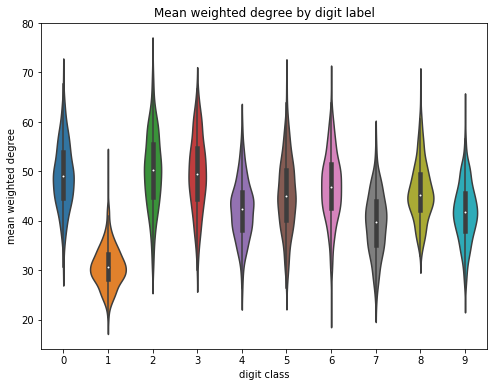

In [6]:
g_xs_mean_degree_by_class = pd.DataFrame({'digit class': mnist.test_labels[rand_inds],
                                          'mean weighted degree': [float(g.vp['degree'].a.mean()) for g in g_xs]})
plt.figure(figsize=(8,6))
sns.violinplot(x='digit class', y='mean weighted degree', data=g_xs_mean_degree_by_class)
plt.title('Mean weighted degree by digit label')
plt.show()

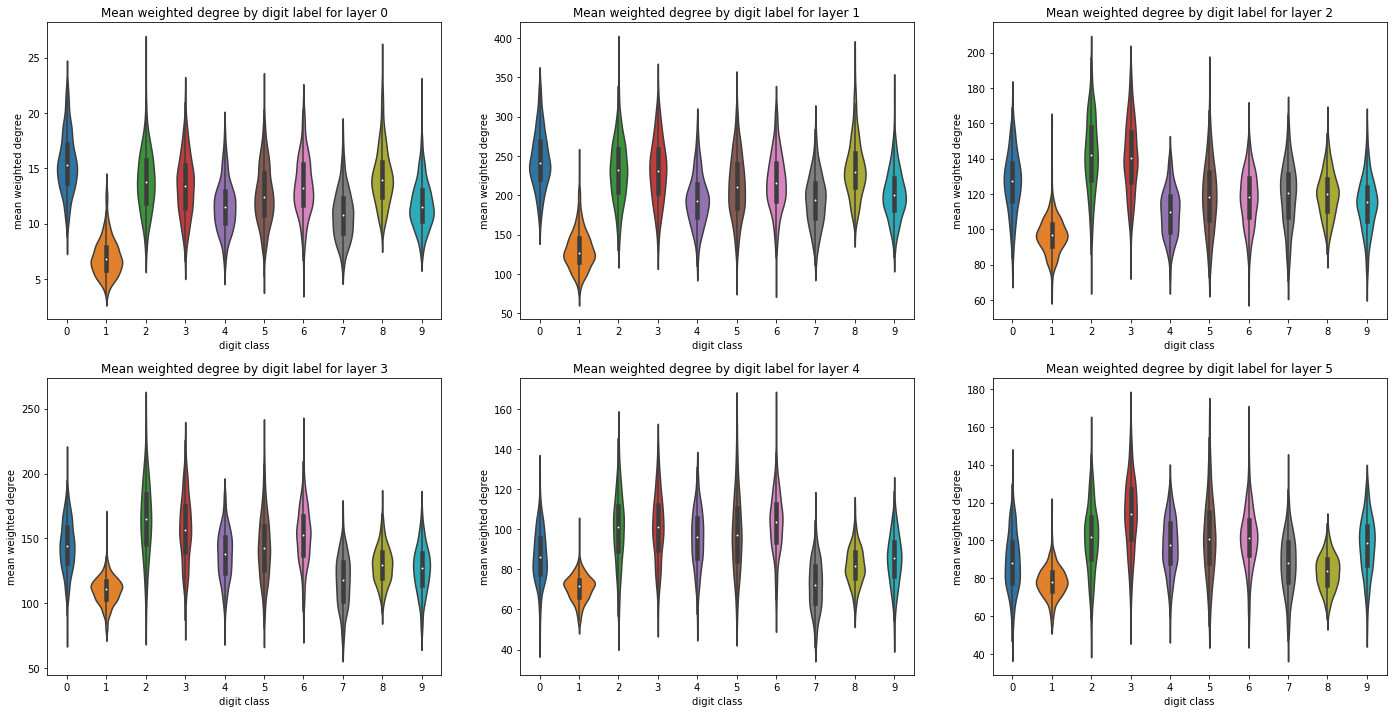

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(3*8,2*6))
for i, (l, st) in enumerate(zip(layer_sizes, np.cumsum(layer_sizes))):
    ax = axs[0 if i < 3 else 1, i%3]
    g_xs_mean_degree_by_class = pd.DataFrame({'digit class': mnist.test_labels[rand_inds],
                                              'mean weighted degree': [float(g.vp['degree'].a[st-l:st].mean()) for g in g_xs]})
    sns.violinplot(x='digit class', y='mean weighted degree', data=g_xs_mean_degree_by_class,
                   ax=ax)
    ax.set_title('Mean weighted degree by digit label for layer {}'.format(i))
plt.show()

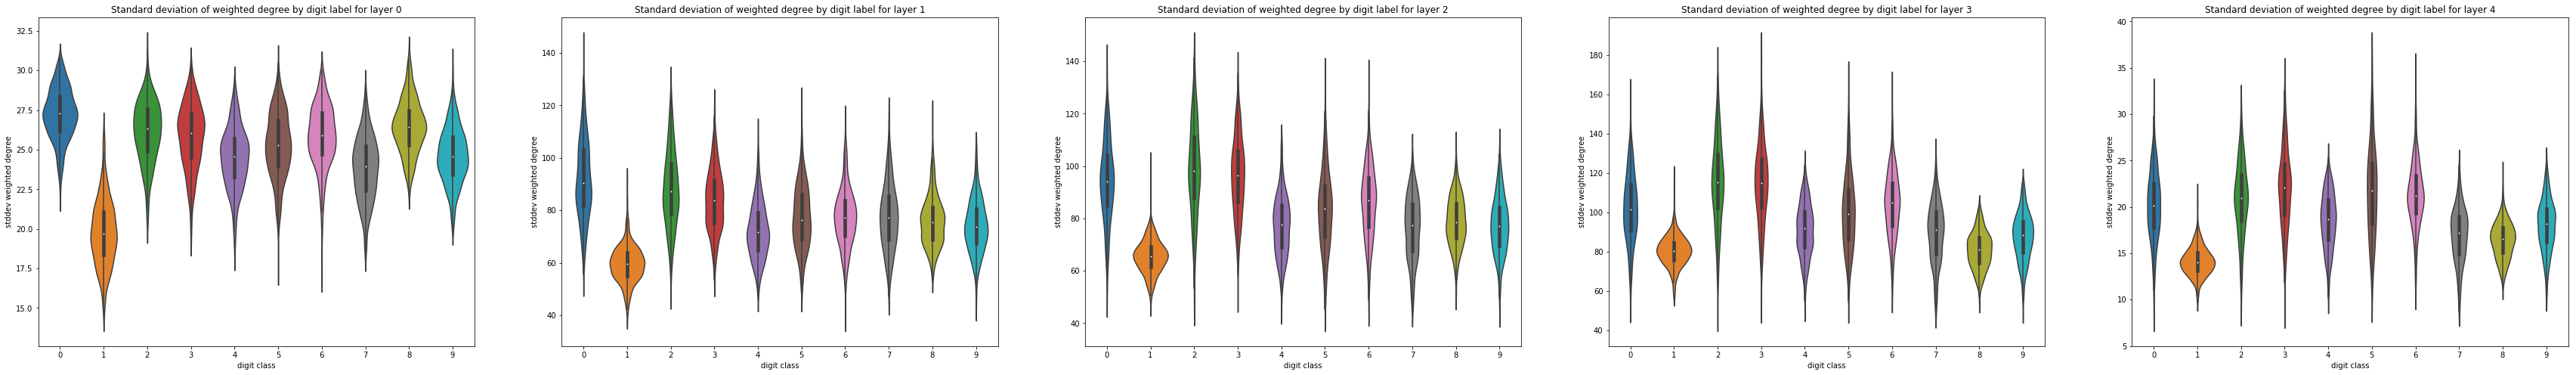

In [8]:
fig, axs = plt.subplots(1, 5, figsize=(5*12,8))
for i, (l, st) in enumerate(zip(layer_sizes[:-1], np.cumsum(layer_sizes))):
    ax = axs[i]
    g_xs_std_degree_by_class = pd.DataFrame({'digit class': mnist.test_labels[rand_inds],
                                              'stddev weighted degree': [float(g.vp['degree'].a[st-l:st].std()) for g in g_xs]})
    sns.violinplot(x='digit class', y='stddev weighted degree', data=g_xs_std_degree_by_class,
                   ax=ax)
    ax.set_title('Standard deviation of weighted degree by digit label for layer {}'.format(i))
plt.show()

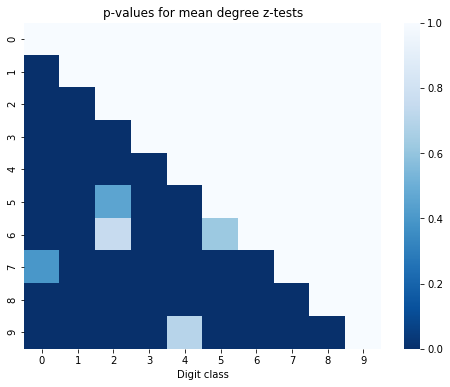

In [9]:
from statsmodels.stats.weightstats import ztest

groups_by_class = g_xs_mean_degree_by_class.groupby('digit class').groups.items()
p_vals = np.ones((10,10))
for i, (c_1, inds_1) in enumerate(groups_by_class):
    for j, (c_2, inds_2) in enumerate(groups_by_class):
        if j >= i:
            continue
        sample_1 = g_xs_mean_degree_by_class.loc[inds_1, 'mean weighted degree']
        sample_2 = g_xs_mean_degree_by_class.loc[inds_2, 'mean weighted degree']
        z, p = ztest(sample_1, sample_2)
        p_vals[i, j] = p
plt.figure(figsize=(8,6))
sns.heatmap(p_vals, cmap='Blues_r')
plt.title('p-values for mean degree z-tests')
plt.xlabel('Digit class')
plt.show()

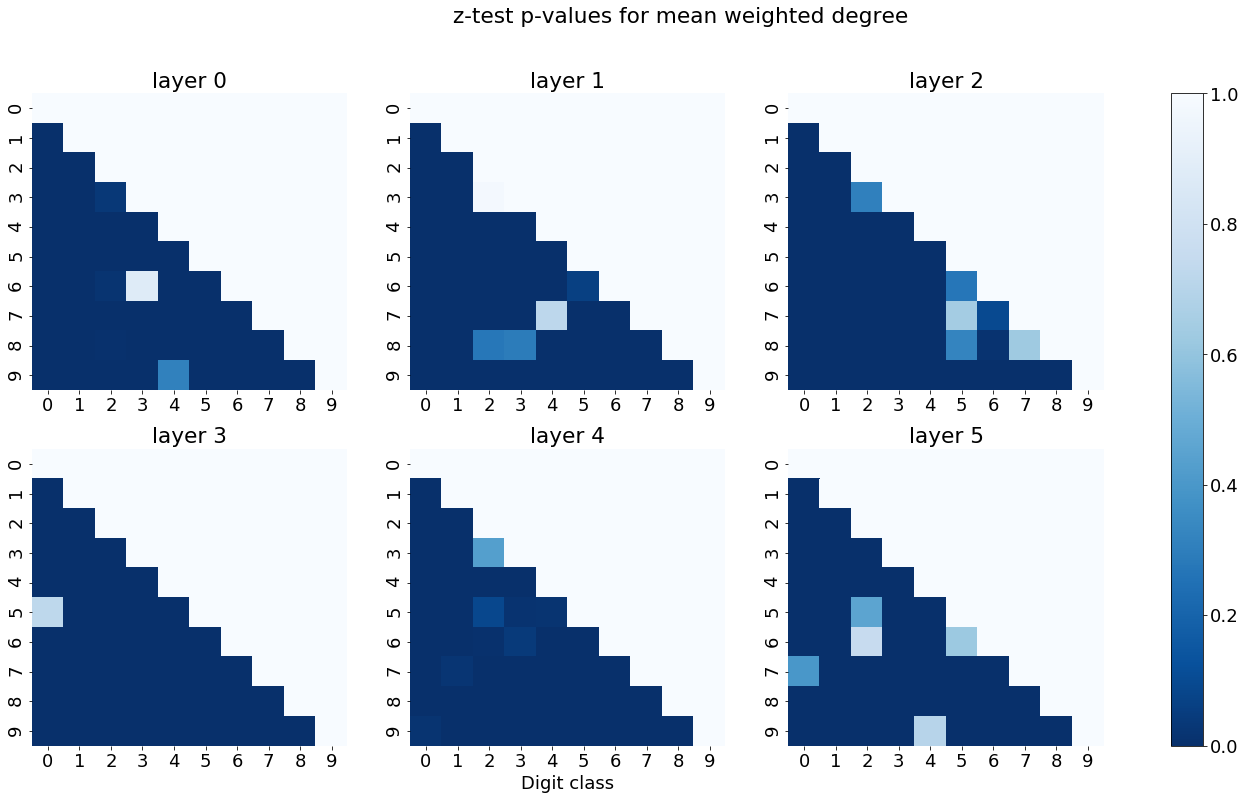

In [17]:
fig, axs = plt.subplots(2, 3, figsize=(3*8,2*6))
for k, (l, st) in enumerate(zip(layer_sizes, np.cumsum(layer_sizes))):
    ax = axs[0 if k < 3 else 1, k%3]
    g_xs_mean_degree_by_class_l = pd.DataFrame({'digit class': mnist.test_labels[rand_inds],
                                                'mean weighted degree': [float(g.vp['degree'].a[st-l:st].mean()) for g in g_xs]})
    groups_by_class = g_xs_mean_degree_by_class_l.groupby('digit class').groups.items()
    p_vals = np.ones((10,10))
    for i, (c_1, inds_1) in enumerate(groups_by_class):
        for j, (c_2, inds_2) in enumerate(groups_by_class):
            if j >= i:
                continue
            sample_1 = g_xs_mean_degree_by_class_l.loc[inds_1, 'mean weighted degree']
            sample_2 = g_xs_mean_degree_by_class_l.loc[inds_2, 'mean weighted degree']
            z, p = ztest(sample_1, sample_2)
            p_vals[i, j] = p
    hmap = sns.heatmap(p_vals, cmap='Blues_r', ax=ax, cbar=False)
    ax.set_title('layer {}'.format(k))
    if k == 4:
        ax.set_xlabel('Digit class')
plt.colorbar(hmap.get_children()[0], ax=axs)
plt.suptitle('z-test p-values for mean weighted degree')
plt.show()

#### Mean weighted degrees vs number of active inputs

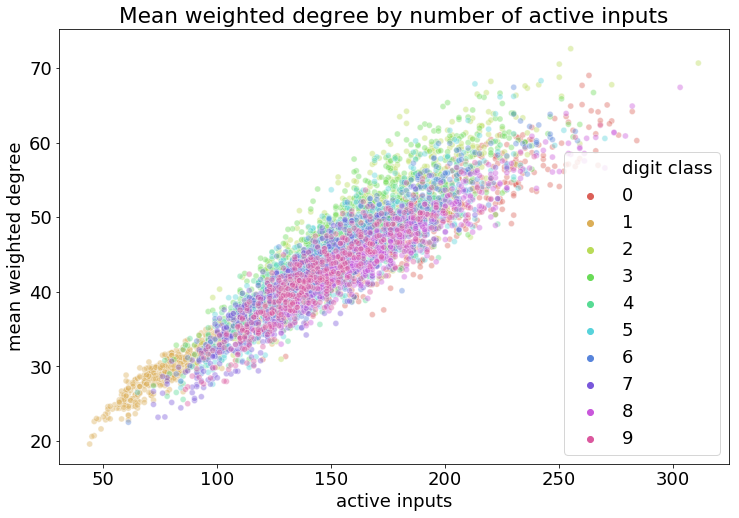

In [18]:
g_xs_degree_by_inputs = pd.DataFrame({'active inputs': np.sum(mnist.X_test[rand_inds], axis=1),
                                      'digit class': mnist.test_labels[rand_inds],
                                      'mean weighted degree': [float(g.vp['degree'].a.mean()) for g in g_xs]})
plt.figure(figsize=(12,8))
sns.scatterplot(x='active inputs', y='mean weighted degree', hue='digit class',
                palette=sns.color_palette('hls', 10), alpha=0.4,
                data=g_xs_degree_by_inputs)
plt.title('Mean weighted degree by number of active inputs')
plt.show()

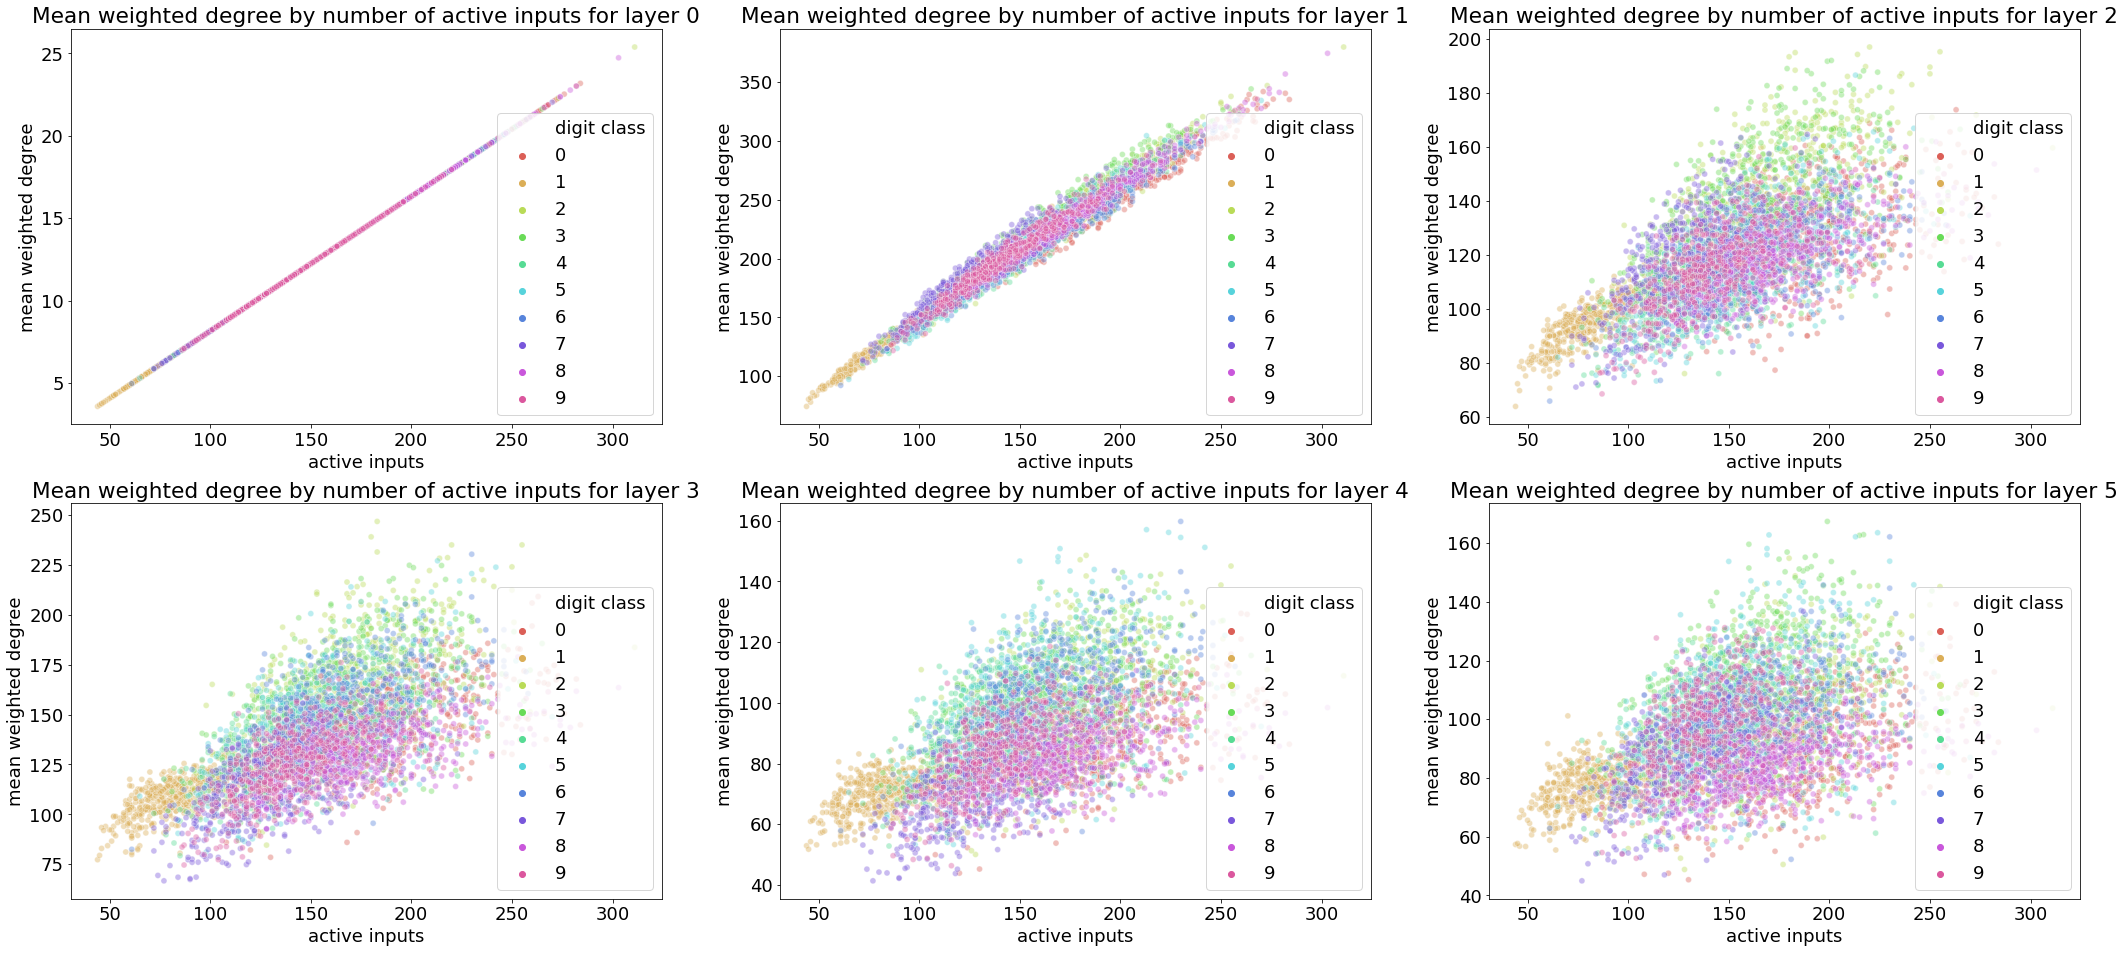

In [19]:
layer_sizes = [784, 64, 64, 64, 64, 10]
fig, axs = plt.subplots(2, 3, figsize=(3*12,2*8))
for i, (l, st) in enumerate(zip(layer_sizes, np.cumsum(layer_sizes))):
    ax = axs[0 if i < 3 else 1, i%3]
    g_xs_mean_degree_vs_inputs = pd.DataFrame({'active inputs': np.sum(mnist.X_test[rand_inds], axis=1),
                                               'digit class': mnist.test_labels[rand_inds],
                                               'mean weighted degree': [float(g.vp['degree'].a[st-l:st].mean()) for g in g_xs]})
    sns.scatterplot(x='active inputs', y='mean weighted degree', hue='digit class',
                    palette=sns.color_palette('hls', 10), alpha=0.4,
                    data=g_xs_mean_degree_vs_inputs,
                    ax=ax)
    ax.set_title('Mean weighted degree by number of active inputs for layer {}'.format(i))
plt.show()

In [20]:
from scipy.spatial.distance import pdist, squareform
def deg_pdf(g):
    degs = g.vp['degree'].a
    pdf = degs / np.sum(degs)
    return pdf
N = 1000
sub_inds = np.concatenate([np.random.choice(np.where(mnist.test_labels[rand_inds] == c)[0], N // 10, replace=False) for c in range(10)], axis=0)
labels, pdfs = zip(*[(mnist.test_labels[rand_inds[i]], deg_pdf(g_xs[i])) for i in sub_inds])
labels, pdfs = np.array(labels), np.array(pdfs)
js_dists = squareform(pdist(pdfs, metric='jensenshannon'))
avg_dists = np.ones((10,10))
for i in range(10):
    for j in range(10):
        avg_dists[i,j] = np.mean(js_dists[i*100:(i+1)*100,j*100:(j+1)*100])

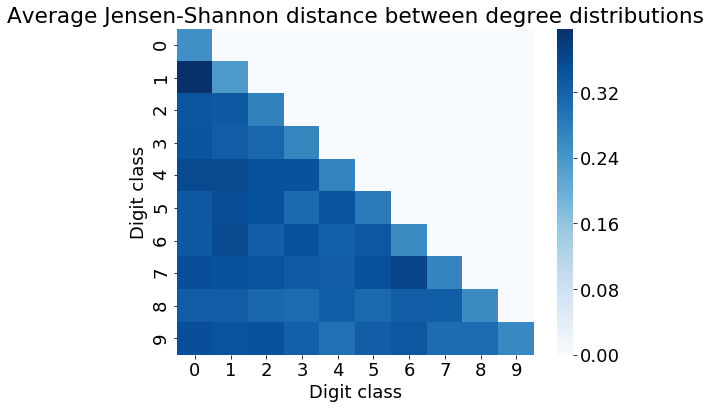

In [23]:
plt.figure(figsize=(8,6))
sns.heatmap(avg_dists*np.tril(np.ones((10,10))), cmap='Blues')
plt.title('Average Jensen-Shannon distance between degree distributions')
plt.xlabel('Digit class')
plt.ylabel('Digit class')
plt.show()

In [22]:
# from graph_tool.centrality import eigenvector
# eig_max, eig_vp = eigenvector(g, weight=g.ep['weight'], max_iter=1.0E5)
# eig_centralities = [(g.vertex_index[v], eig_vp[v]) for v in g.vertices()]
# vs_in = [v for v,_ in eig_centralities if v < input_dims]
# eigs_in = [eigc for v, eigc in eig_centralities if v < input_dims]
# vs1 = [v for v,_ in eig_centralities if v >= input_dims and v < input_dims+hidden_dims]
# eigs1 = [eigc for v, eigc in eig_centralities if v >= input_dims and v < input_dims+hidden_dims]
# vs2 = [v for v,_ in eig_centralities if v >= input_dims+hidden_dims and v < input_dims+2*hidden_dims]
# eigs2 = [eigc for v, eigc in eig_centralities if v >= input_dims+hidden_dims and v < input_dims+2*hidden_dims]
# vs3 = [v for v,_ in eig_centralities if v >= input_dims+2*hidden_dims and v < input_dims+3*hidden_dims]
# eigs3 = [eigc for v, eigc in eig_centralities if v >= input_dims+2*hidden_dims and v < input_dims+3*hidden_dims]
# vs4 = [v for v,_ in eig_centralities if v >= input_dims+3*hidden_dims and v < input_dims+4*hidden_dims]
# eigs4 = [eigc for v, eigc in eig_centralities if v >= input_dims+3*hidden_dims and v < input_dims+4*hidden_dims]
# vs_out = [v for v,_ in eig_centralities if v >= input_dims+4*hidden_dims]
# eigs_out = [eigc for v, eigc in eig_centralities if v >= input_dims+4*hidden_dims]
# plt.figure(figsize=(16,6))
# plt.subplot(1,2,1)
# plt.scatter(vs_in, eigs_in, c='gray')
# plt.scatter(vs1, eigs1, c='r')
# plt.scatter(vs2, eigs2, c='b')
# plt.scatter(vs3, eigs3, c='g')
# plt.scatter(vs4, eigs4, c='c')
# plt.scatter(vs_out, eigs_out, c='m')
# plt.legend(['inputs', 'layer 1', 'layer 2', 'layer 3', 'layer 4', 'output'])
# plt.xlabel('vertex label')
# plt.ylabel('eigenvector centrality')
# plt.title('Hidden layers + inputs')
# plt.subplot(1,2,2)
# plt.scatter(vs1, eigs1, c='r')
# plt.scatter(vs2, eigs2, c='b')
# plt.scatter(vs3, eigs3, c='g')
# plt.scatter(vs4, eigs4, c='c')
# plt.scatter(vs_out, eigs_out, c='m')
# plt.legend(['layer 1', 'layer 2', 'layer 3', 'layer 4', 'output'])
# plt.xlabel('vertex label')
# plt.ylabel('eigenvector centrality')
# plt.title('Hidden layers only')
# plt.suptitle('Eigenvector centrality vs. nodes')
# plt.show()